In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
current_pwd = os.getcwd()

possible_paths = [
    '/home/export/soheuny/SRFinder/soheun/notebooks', 
    '/home/soheuny/HH4bsim/soheun/notebooks'
]
    
assert os.getcwd() in possible_paths, f"Did you change the path? It should be one of {possible_paths}"
os.chdir("..")

In [2]:
features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

In [3]:
import numpy as np
from events_data import EventsData
from dataset import SCDatasetInfo

def plot_sr_stats(events, sr_stats, ax, label, **plot_kwargs):
    assert len(events) == len(sr_stats)

    sr_stats_argsort = np.argsort(sr_stats)[::-1]
    weights = events.weights[sr_stats_argsort]
    is_signal = events.is_signal[sr_stats_argsort]
    is_4b = events.is_4b[sr_stats_argsort]

    ax.plot(
        np.cumsum(weights * is_4b) / np.sum(weights * is_4b),
        np.cumsum(weights * is_signal) / np.sum(weights * is_signal),           
        label=label,
        **plot_kwargs,
    )

def get_is_signal(scdinfo: SCDatasetInfo, signal_filename: str):
    # Now show the answer
    is_signals = []
    for file, file_len in zip(scdinfo.files, scdinfo.get_file_lengths()):
        is_signals.append(
            np.full(file_len, True)
            if file.name == signal_filename
            else np.full(file_len, False)
        )
    is_signal = np.concatenate(is_signals)
    return is_signal



def events_from_scdinfo(scdinfo: SCDatasetInfo, features: list, signal_filename: str) -> EventsData:
    df = scdinfo.fetch_data()
    df["signal"] = get_is_signal(scdinfo, signal_filename)
    events = EventsData.from_dataframe(df, features)

    return events

def hist_events_by_labels(events: EventsData, values: np.ndarray, bins, ax, **hist_kwargs):
    assert len(values) == len(events)   
    ax.hist(values[events.is_3b], 
                        bins=bins, histtype="step", label="3b", 
                        weights=events.weights[events.is_3b], 
                        **hist_kwargs)
    ax.hist(values[events.is_bg4b], 
                bins=bins, histtype="step", label="bg4b", 
                weights=events.weights[events.is_bg4b], 
                **hist_kwargs)
    ax.hist(values[events.is_signal], 
                bins=bins, histtype="step", label="signal", 
                weights=events.weights[events.is_signal], 
                **hist_kwargs)
    
    
def get_histogram_info(events_original: EventsData, values, bins, reweights):
    assert len(events_original) == len(values)

    if isinstance(bins, int):
        # calculate quantiles
        q = np.linspace(0, 1, bins + 1)
        bins = np.quantile(values, q)
        
    events_clone = events_original.clone()
    weights_rw = np.where(events_clone.is_4b, 1, reweights) * events_clone.weights
    weights_rw_sq = np.where(events_clone.is_4b, 1, reweights**2) * events_clone.weights
    
    hist_3b, _ = np.histogram(values[events_original.is_3b], bins=bins, 
                              weights=weights_rw[events_original.is_3b])
    hist_bg4b, _ = np.histogram(values[events_original.is_bg4b], bins=bins, 
                                weights=weights_rw[events_original.is_bg4b])
    hist_signal, _ = np.histogram(values[events_original.is_signal], bins=bins, 
                                  weights=weights_rw[events_original.is_signal])
    hist_4b, _ = np.histogram(values[events_original.is_4b], bins=bins, 
                              weights=weights_rw[events_original.is_4b])
    hist_3b_sq, _ = np.histogram(values[events_original.is_3b], bins=bins,
                                    weights=weights_rw_sq[events_original.is_3b])

    # std_est = np.sqrt((hist_3b + hist_4b) / 2)
    # is_sampled = std_est > 0
    
    std_est = np.sqrt(hist_4b + hist_3b_sq)
    is_sampled = std_est > 0
    sigma = (hist_4b - hist_3b)[is_sampled]  / std_est[is_sampled]
    sigma_avg = np.sqrt(np.mean(sigma**2))
    sigma_bg4b = (hist_bg4b - hist_3b)[is_sampled] / std_est[is_sampled]
    sigma_avg_bg4b = np.sqrt(np.mean(sigma_bg4b**2))
    df = np.sum(is_sampled)

    return {
        "hist_3b": hist_3b,
        "hist_bg4b": hist_bg4b,
        "hist_signal": hist_signal,
        "hist_4b": hist_4b,
        "std_est": std_est,
        "sigma": sigma,
        "sigma_avg": sigma_avg,
        "sigma_bg4b": sigma_bg4b,
        "sigma_avg_bg4b": sigma_avg_bg4b,
        "df": df,
    }

In [4]:
import torch
from fvt_classifier import FvTClassifier
from tst_info import TSTInfo
import yaml
import matplotlib.pyplot as plt

config_filename = "configs/counting_test_high_4b_in_CR.yml"


config = yaml.safe_load(open(config_filename, "r"))
experiment_name = config["experiment_name"]
n_3b = config["n_3b"]
ratio_4b = config["ratio_4b"]

hashes, hparams = TSTInfo.find({
    "experiment_name": experiment_name,
    "n_3b": n_3b,
    "ratio_4b": ratio_4b,
}, return_hparams=True)

seeds = np.unique([hp["seed"] for hp in hparams])
signal_ratios = np.unique([hp["signal_ratio"] for hp in hparams])
n_3bs = np.unique([hp["n_3b"] for hp in hparams])

tst_results = []
result_size = 0

0it [00:00, ?it/s]

1793it [00:04, 446.16it/s]


In [5]:
import pandas as pd
from scipy import stats

pd.set_option('display.max_rows', 500)

experiment_name = "counting_test_high_4b_in_CR"
tst_results_summary_df = pd.read_csv(f"./data/tsv/tst_results_summary_{experiment_name}.tsv", sep="\t")

def get_p_value(row, deg_f):
    return stats.chi2.sf(deg_f * row**2, deg_f)


tst_results_summary_df["p_SR"] = get_p_value(tst_results_summary_df["sigma_avg_SR"], tst_results_summary_df["df_SR"])
tst_results_summary_df["p_bg4b_SR"] = get_p_value(tst_results_summary_df["sigma_avg_bg4b_SR"], tst_results_summary_df["df_SR"])
tst_results_summary_df["p_CR"] = get_p_value(tst_results_summary_df["sigma_avg_CR"], tst_results_summary_df["df_CR"])
tst_results_summary_df["p_bg4b_CR"] = get_p_value(tst_results_summary_df["sigma_avg_bg4b_CR"], tst_results_summary_df["df_CR"])

sig_level = 0.05
tst_results_summary_df["rejected_SR"] = tst_results_summary_df["p_SR"] < sig_level
tst_results_summary_df["rejected_bg4b_SR"] = tst_results_summary_df["p_bg4b_SR"] < sig_level
tst_results_summary_df["rejected_CR"] = tst_results_summary_df["p_CR"] < sig_level
tst_results_summary_df["rejected_bg4b_CR"] = tst_results_summary_df["p_bg4b_CR"] < sig_level

pd.set_option('display.max_rows', 500)
tst_results_summary_df.groupby(["signal_ratio", "nbin", "reweight"]).mean()

FileNotFoundError: [Errno 2] No such file or directory: 'tst_results_summary_counting_test_high_4b_in_CR.tsv'

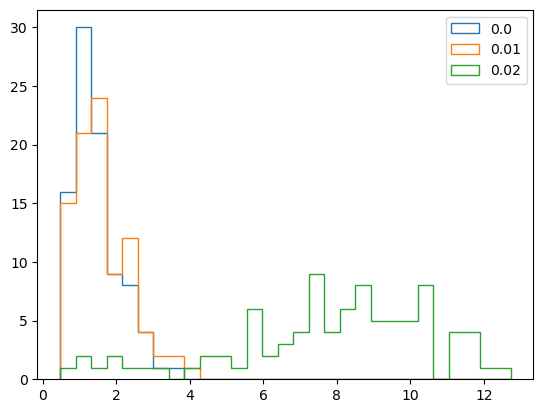

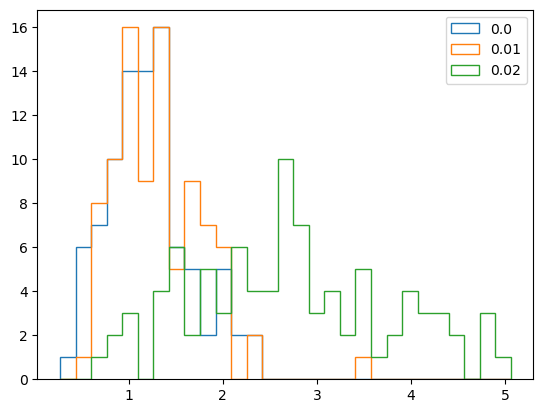

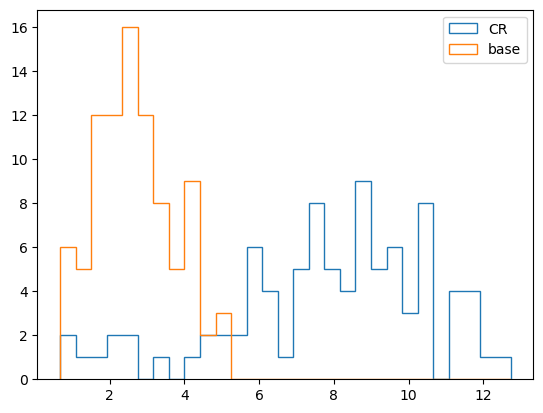

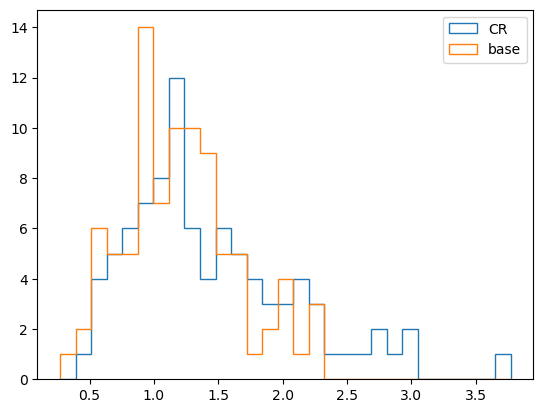

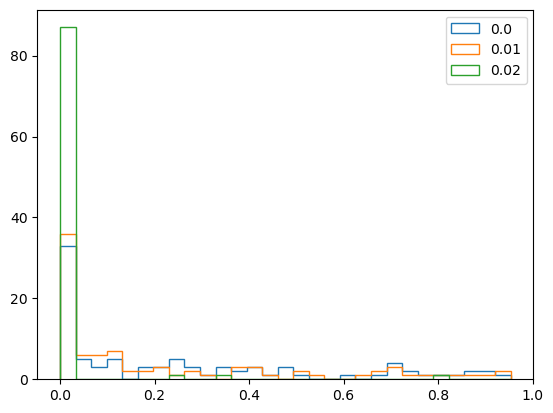

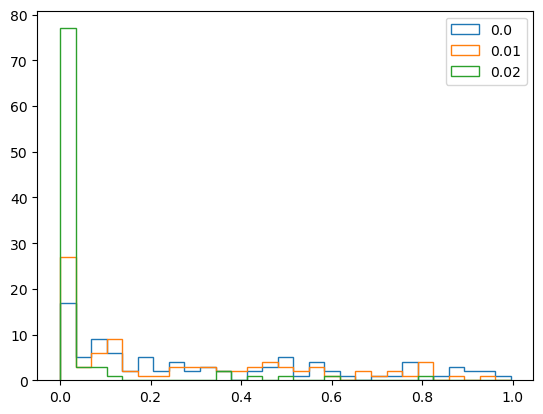

In [54]:
def get_sigma_avg_SR(signal_ratio, nbin, method):
    return tst_results_summary_df.groupby(["signal_ratio", "nbin", "reweight"]).get_group((signal_ratio, nbin, method))["sigma_avg_SR"].values

def get_p_SR(signal_ratio, nbin, method):
    return tst_results_summary_df.groupby(["signal_ratio", "nbin", "reweight"]).get_group((signal_ratio, nbin, method))["p_SR"].values

sigma1 = get_sigma_avg_SR(0.0, 5, "CR")
sigma2 = get_sigma_avg_SR(0.01, 5, "CR")
sigma3 = get_sigma_avg_SR(0.02, 5, "CR")

xmin = np.min(np.concatenate([sigma1, sigma2, sigma3]))
xmax = np.max(np.concatenate([sigma1, sigma2, sigma3]))
bins = np.linspace(xmin, xmax, 30)

plt.hist(sigma1, bins=bins, histtype="step", label="0.0")
plt.hist(sigma2, bins=bins, histtype="step", label="0.01")
plt.hist(sigma3, bins=bins, histtype="step", label="0.02")
plt.legend()
plt.show()

sigma1 = get_sigma_avg_SR(0.0, 5, "base")
sigma2 = get_sigma_avg_SR(0.01, 5, "base")
sigma3 = get_sigma_avg_SR(0.02, 5, "base")

xmin = np.min(np.concatenate([sigma1, sigma2, sigma3]))
xmax = np.max(np.concatenate([sigma1, sigma2, sigma3]))
bins = np.linspace(xmin, xmax, 30)

plt.hist(sigma1, bins=bins, histtype="step", label="0.0")
plt.hist(sigma2, bins=bins, histtype="step", label="0.01")
plt.hist(sigma3, bins=bins, histtype="step", label="0.02")
plt.legend()
plt.show()

sigma1 = get_sigma_avg_SR(0.02, 5, "CR")
sigma2 = get_sigma_avg_SR(0.02, 5, "base")

xmin = np.min(np.concatenate([sigma1, sigma2]))
xmax = np.max(np.concatenate([sigma1, sigma2]))
bins = np.linspace(xmin, xmax, 30)

plt.hist(sigma1, bins=bins, histtype="step", label="CR")
plt.hist(sigma2, bins=bins, histtype="step", label="base")
plt.legend()
plt.show()

sigma1 = get_sigma_avg_SR(0.0, 5, "CR")
sigma2 = get_sigma_avg_SR(0.0, 5, "base")

xmin = np.min(np.concatenate([sigma1, sigma2]))
xmax = np.max(np.concatenate([sigma1, sigma2]))
bins = np.linspace(xmin, xmax, 30)

plt.hist(sigma1, bins=bins, histtype="step", label="CR")
plt.hist(sigma2, bins=bins, histtype="step", label="base")
plt.legend()
plt.show()

p1 = get_p_SR(0.0, 5, "CR")
p2 = get_p_SR(0.01, 5, "CR")
p3 = get_p_SR(0.02, 5, "CR")

xmin = np.min(np.concatenate([p1, p2, p3]))
xmax = np.max(np.concatenate([p1, p2, p3]))
bins = np.linspace(xmin, xmax, 30)

plt.hist(p1, bins=bins, histtype="step", label="0.0")
plt.hist(p2, bins=bins, histtype="step", label="0.01")
plt.hist(p3, bins=bins, histtype="step", label="0.02")
plt.legend()
plt.show()

p1 = get_p_SR(0.0, 5, "base")
p2 = get_p_SR(0.01, 5, "base")
p3 = get_p_SR(0.02, 5, "base")

xmin = np.min(np.concatenate([p1, p2, p3]))
xmax = np.max(np.concatenate([p1, p2, p3]))
bins = np.linspace(xmin, xmax, 30)

plt.hist(p1, bins=bins, histtype="step", label="0.0")
plt.hist(p2, bins=bins, histtype="step", label="0.01")
plt.hist(p3, bins=bins, histtype="step", label="0.02")
plt.legend()
plt.show()

1.9599639845400538


nbin  sigma_avg_SR  sigma_avg_bg4b_SR  \
signal_ratio seed reweight                                          
0.00         0    CR         1.0      0.508436           0.508436   
                  base       1.0      0.511660           0.511660   
             1    CR         1.0      3.229619           3.229619   
                  base       1.0      0.759856           0.759856   
             2    CR         1.0      4.000529           4.000529   
                  base       1.0      3.011712           3.011712   
0.01         0    CR         1.0      2.398912           5.109375   
                  base       1.0      3.442415           6.135276   
             1    CR         1.0      0.386191           3.404178   
                  base       1.0      3.691625           7.381697   
0.02         0    CR         1.0      7.923330           6.581985   
                  base       1.0      3.082053          15.884451   
             1    CR         1.0      9.977938           3.256720   
                  base       1.0      3.186649           9.228771   

                            sigma_avg_CR  sigma_avg_bg4b_CR  \
signal_ratio seed reweight                                    
0.00         0    CR            2.557318           2.557318   
                  base          3.717957           3.717957   
             1    CR            2.292809           2.292809   
                  base          1.944607           1.944607   
             2    CR            2.353555           2.353555   
                  base          0.540519           0.540519   
0.01         0    CR            2.972216           5.393964   
                  base          1.094663           1.341732   
             1    CR            1.785176           0.189984   
                  base          7.359668           9.294626   
0.02         0    CR            6.473315           4.856341   
                  base          1.773112           3.359784   
             1    CR            1.999085           0.056725   
                  base          1.060043           0.993028   

                            initialize_with_fvt  df_SR  df_CR  
signal_ratio seed reweight                                     
0.00         0    CR                        0.0    1.0    1.0  
                  base                      0.0    1.0    1.0  
             1    CR                        0.0    1.0    1.0  
                  base                      0.0    1.0    1.0  
             2    CR                        0.0    1.0    1.0  
                  base                      0.0    1.0    1.0  
0.01         0    CR                        0.0    1.0    1.0  
                  base                      0.0    1.0    1.0  
             1    CR                        0.0    1.0    1.0  
                  base                      0.0    1.0    1.0  
0.02         0    CR                        0.0    1.0    1.0  
                  base                      0.0    1.0    1.0  
             1    CR                        0.0    1.0    1.0  
                  base                      0.0    1.0    1.0

1793it [00:02, 732.29it/s]
  0%|          | 0/90 [00:00<?, ?it/s]

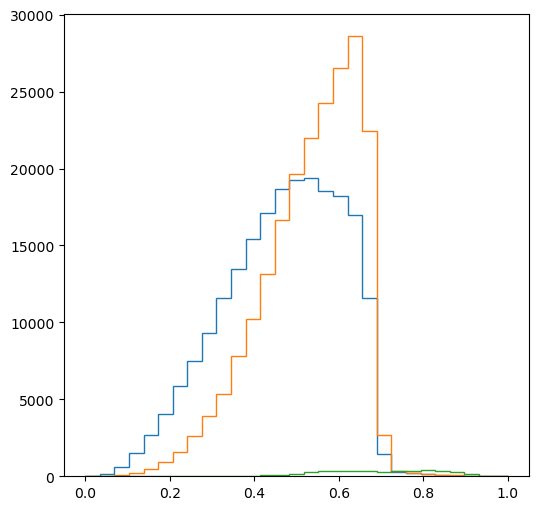

  1%|          | 1/90 [00:11<17:17, 11.66s/it]

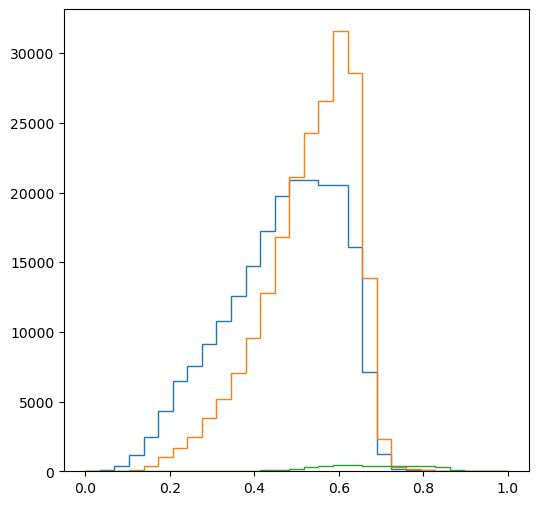

  2%|▏         | 2/90 [00:24<18:19, 12.49s/it]


KeyboardInterrupt: 

In [6]:
import sys
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

plt.rcParams["lines.markersize"] = 3

verbose = False
show_plots = False
hparam_filter = {
    "experiment_name": lambda x: x in ["counting_test_high_4b_in_CR"],
    "signal_ratio": 0.02,
}

experiment_name = "counting_test_high_4b_in_CR"
hashes = TSTInfo.find(hparam_filter, sort_by=["seed", "signal_ratio"])


for tstinfo_hash in (pbar := tqdm.tqdm(hashes)):
    
    tstinfo = TSTInfo.load(tstinfo_hash)
    signal_filename = tstinfo.hparams["signal_filename"]
    seed = tstinfo.hparams["seed"]
    signal_ratio = tstinfo.hparams["signal_ratio"]        
    experiment_name = tstinfo.hparams["experiment_name"]

    scdinfo_tst = tstinfo.scdinfo_tst
    events_tst = events_from_scdinfo(scdinfo_tst, features, signal_filename)
    
    base_fvt_hash = tstinfo.base_fvt_tinfo_hash
    fvt_model = FvTClassifier.load_from_checkpoint(f"./data/checkpoints/{base_fvt_hash}_best.ckpt")
    fvt_model.eval()
    
    events_tst.set_model_scores(fvt_model)
    CR_fvt_hash = tstinfo.CR_fvt_tinfo_hash
    CR_model = FvTClassifier.load_from_checkpoint(f"./data/checkpoints/{CR_fvt_hash}_best.ckpt")
    CR_model.eval()
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    bins = np.linspace(0, 1, 30)
    hist_events_by_labels(events_tst, events_tst.fvt_score, bins=bins, ax=ax)
    plt.show()


[rank: 0] Seed set to 42
[rank: 0] Seed set to 42
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | P

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]

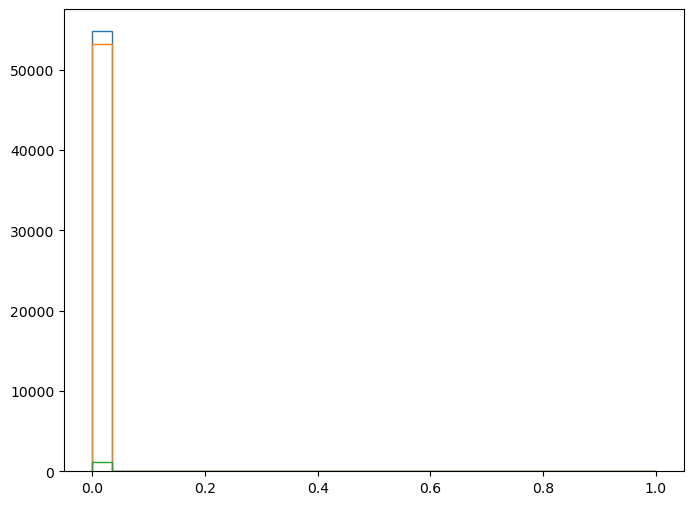

Epoch 0: 100%|██████████| 767/767 [00:18<00:00, 40.91it/s, v_num=72]       

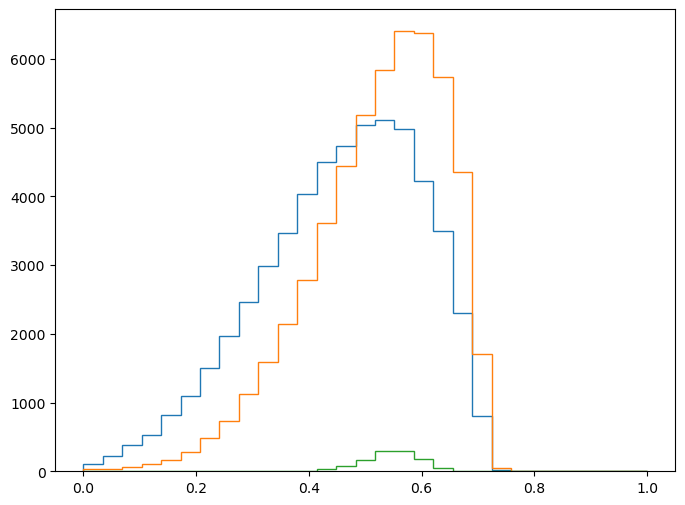

Epoch 1: 100%|██████████| 767/767 [00:20<00:00, 36.98it/s, v_num=72, val_loss=0.663, train_loss=0.669]

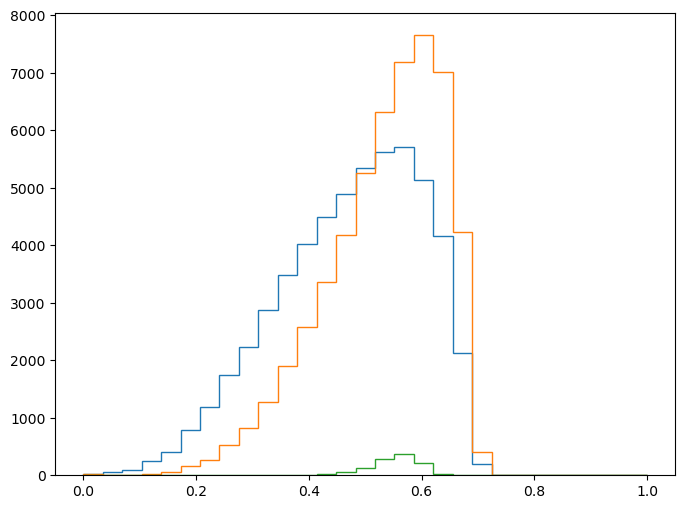

Epoch 2: 100%|██████████| 767/767 [00:19<00:00, 39.74it/s, v_num=72, val_loss=0.661, train_loss=0.663]

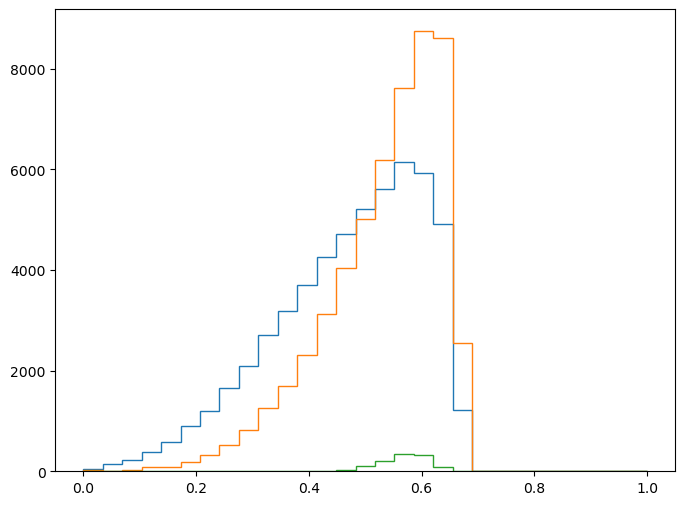

Epoch 3: 100%|██████████| 767/767 [00:19<00:00, 40.13it/s, v_num=72, val_loss=0.661, train_loss=0.662]

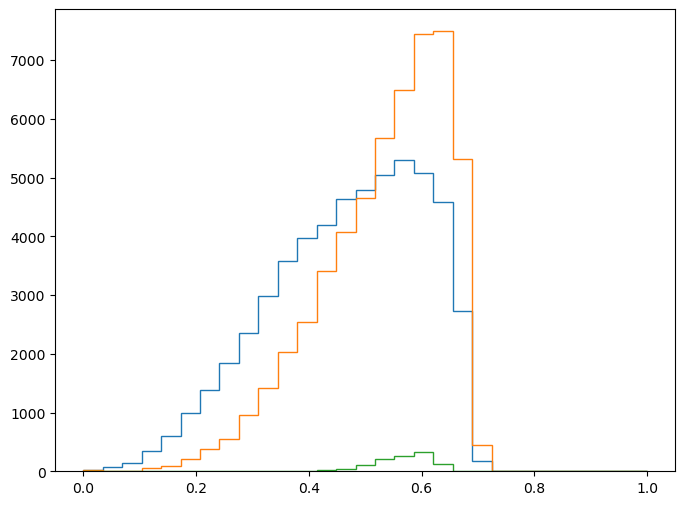

Epoch 4: 100%|██████████| 767/767 [00:19<00:00, 40.22it/s, v_num=72, val_loss=0.660, train_loss=0.662]

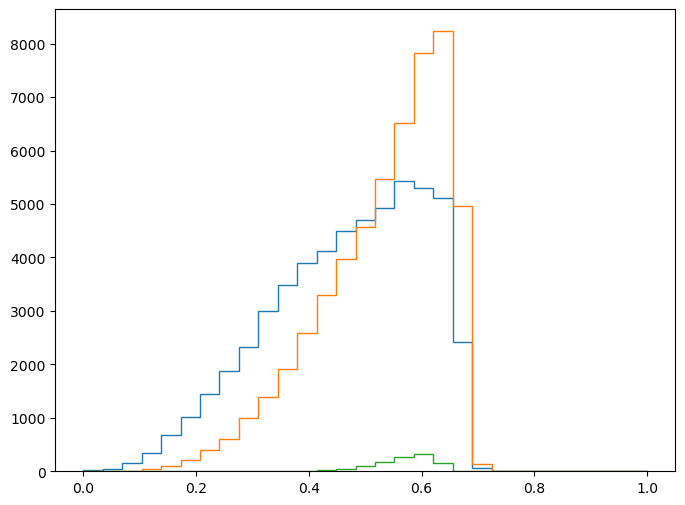

Epoch 5: 100%|██████████| 767/767 [00:19<00:00, 39.72it/s, v_num=72, val_loss=0.660, train_loss=0.662]

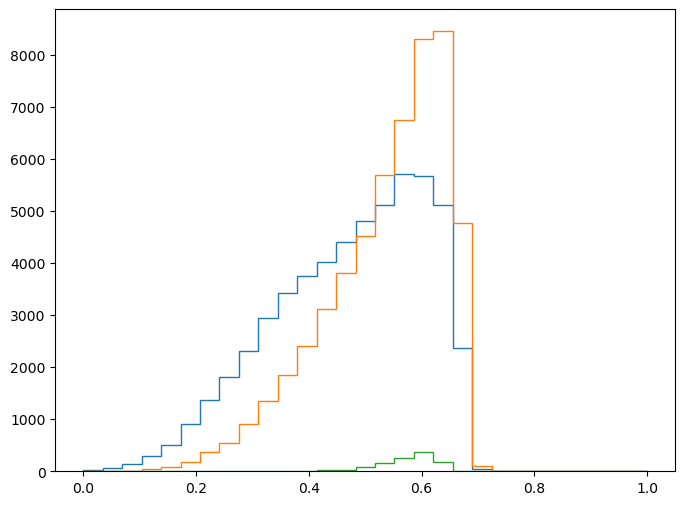

Epoch 6: 100%|██████████| 767/767 [00:20<00:00, 37.45it/s, v_num=72, val_loss=0.660, train_loss=0.662]

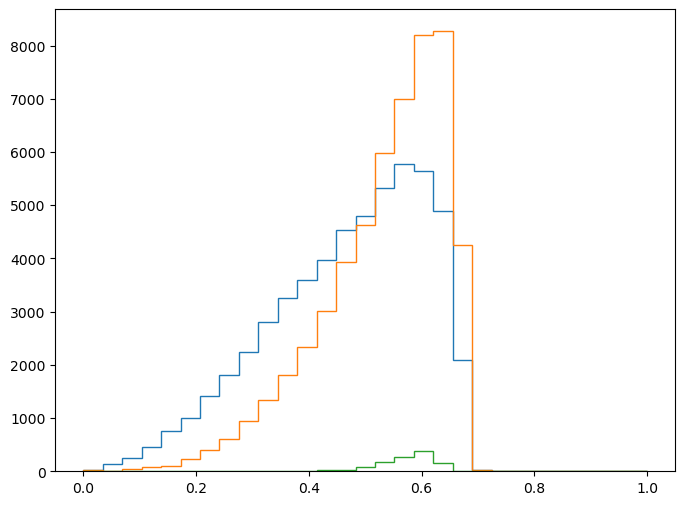

Epoch 7: 100%|██████████| 767/767 [00:19<00:00, 39.31it/s, v_num=72, val_loss=0.660, train_loss=0.661]

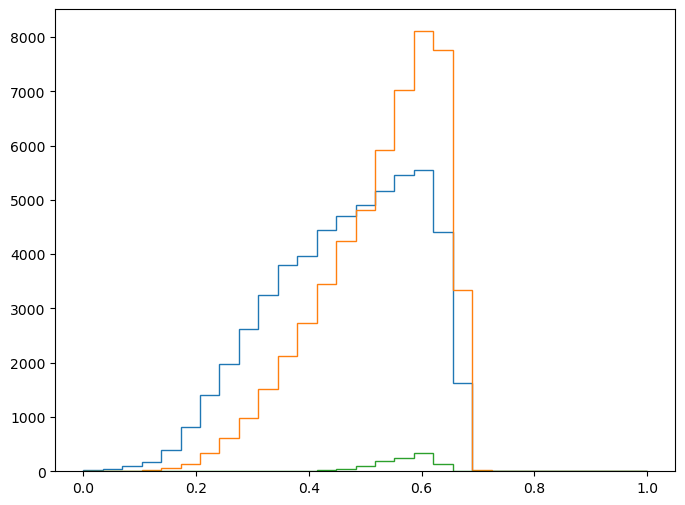

Epoch 8: 100%|██████████| 767/767 [00:19<00:00, 39.23it/s, v_num=72, val_loss=0.660, train_loss=0.661]

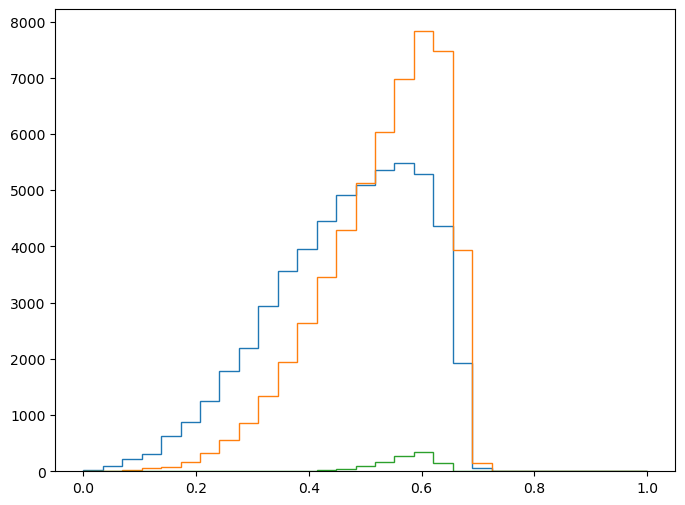

Epoch 9: 100%|██████████| 767/767 [00:18<00:00, 40.41it/s, v_num=72, val_loss=0.660, train_loss=0.661]

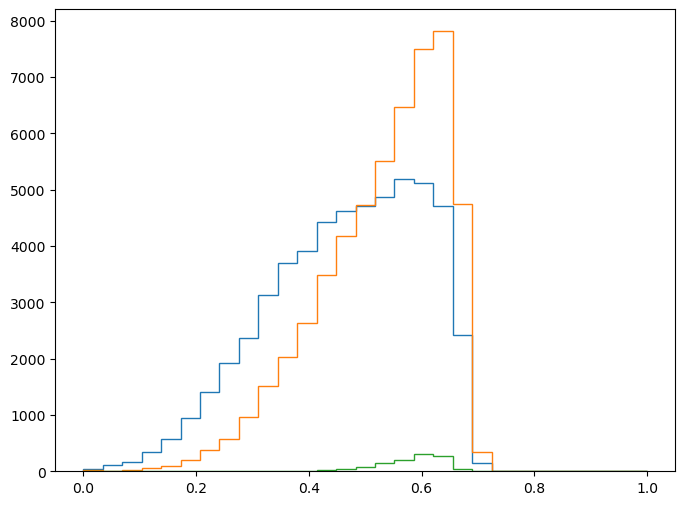

Epoch 10: 100%|██████████| 767/767 [00:18<00:00, 41.30it/s, v_num=72, val_loss=0.660, train_loss=0.661]

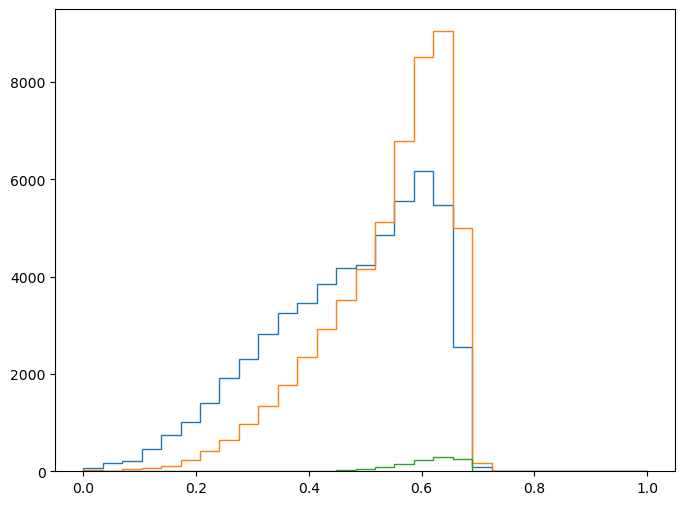

Epoch 11: 100%|██████████| 767/767 [00:18<00:00, 40.73it/s, v_num=72, val_loss=0.660, train_loss=0.661]

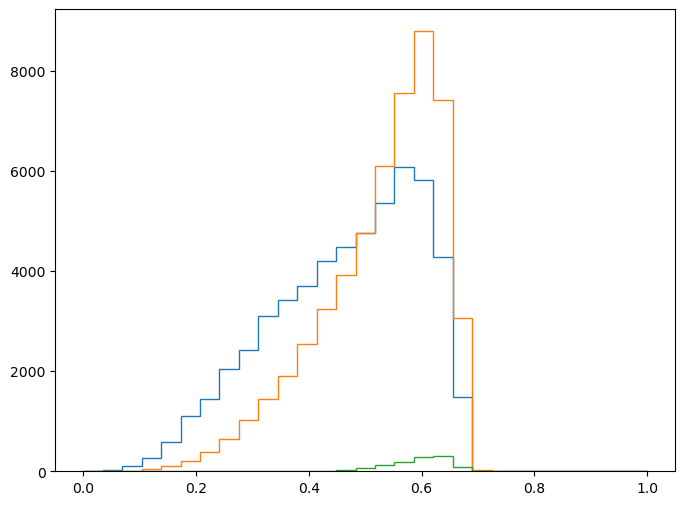

Epoch 12: 100%|██████████| 767/767 [00:19<00:00, 40.02it/s, v_num=72, val_loss=0.660, train_loss=0.660]

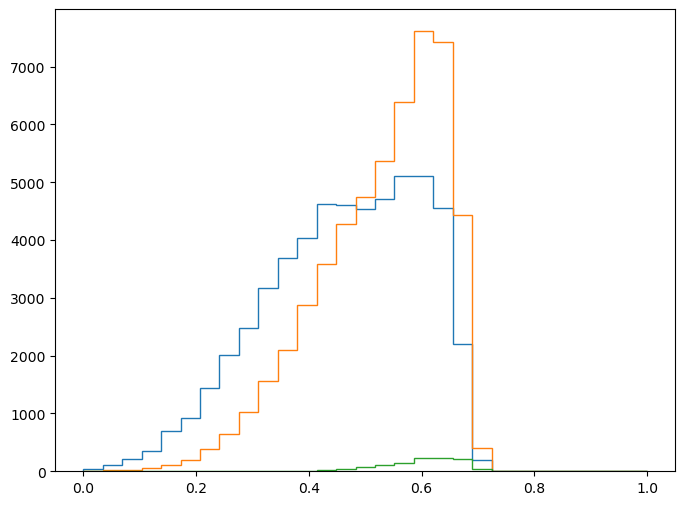

Epoch 13: 100%|██████████| 767/767 [00:19<00:00, 38.68it/s, v_num=72, val_loss=0.660, train_loss=0.661]

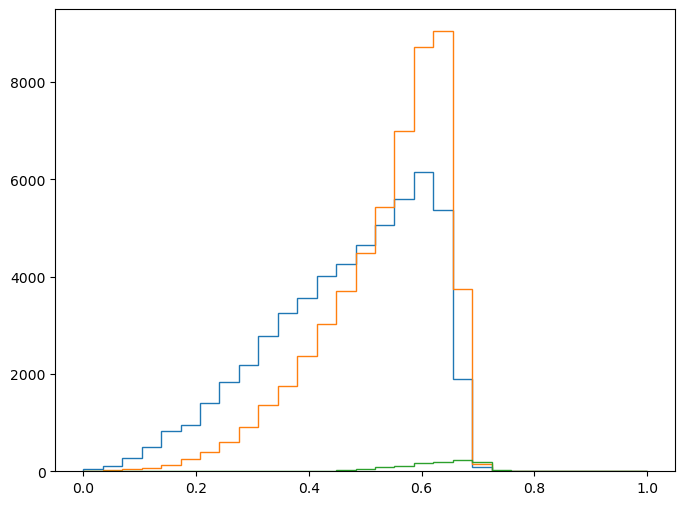

Epoch 14: 100%|██████████| 767/767 [00:19<00:00, 39.29it/s, v_num=72, val_loss=0.660, train_loss=0.660]

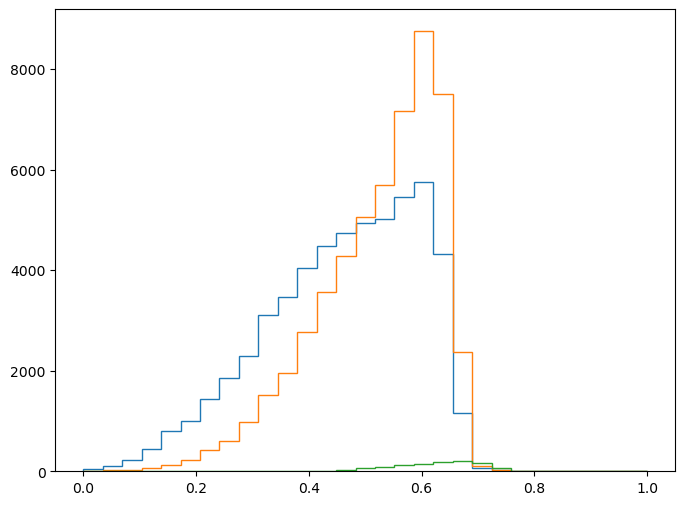

Epoch 15: 100%|██████████| 767/767 [00:19<00:00, 39.92it/s, v_num=72, val_loss=0.660, train_loss=0.660]

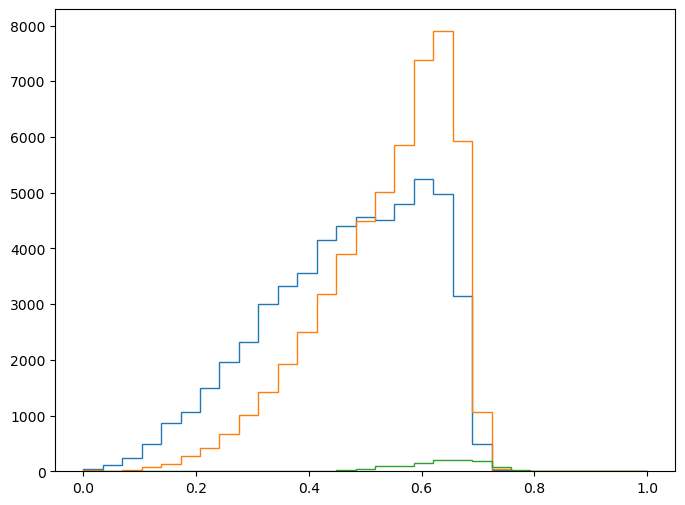

Epoch 16: 100%|██████████| 767/767 [00:19<00:00, 39.63it/s, v_num=72, val_loss=0.659, train_loss=0.660]

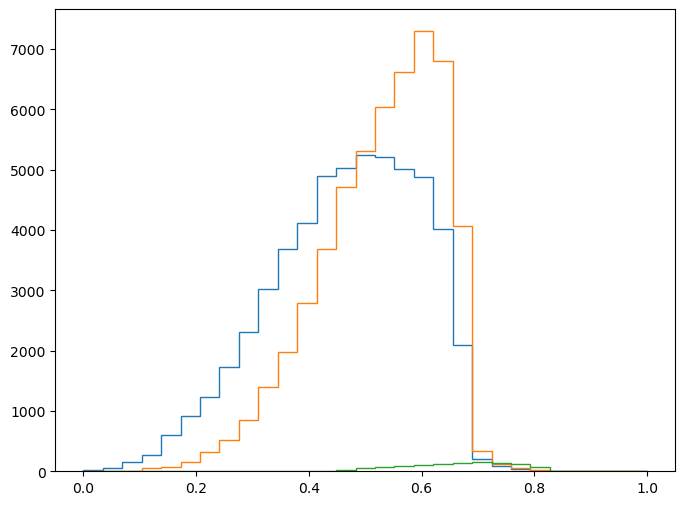

Epoch 17: 100%|██████████| 767/767 [00:20<00:00, 37.55it/s, v_num=72, val_loss=0.659, train_loss=0.660]

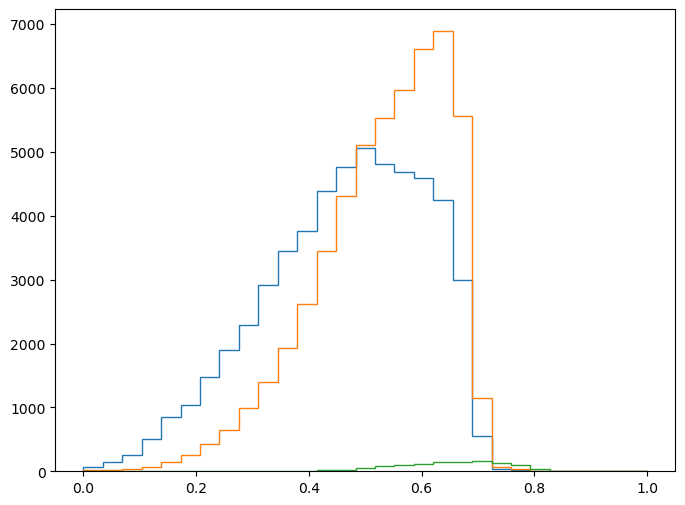

Epoch 18: 100%|██████████| 767/767 [00:18<00:00, 41.32it/s, v_num=72, val_loss=0.659, train_loss=0.660]

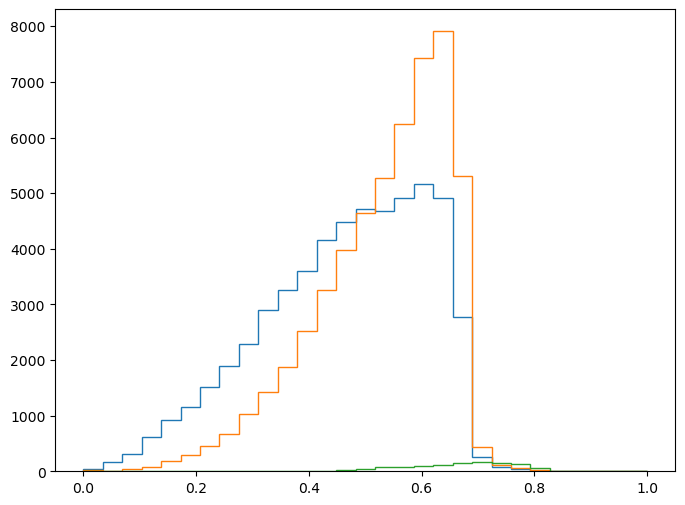

Epoch 19: 100%|██████████| 767/767 [00:19<00:00, 38.45it/s, v_num=72, val_loss=0.659, train_loss=0.660]

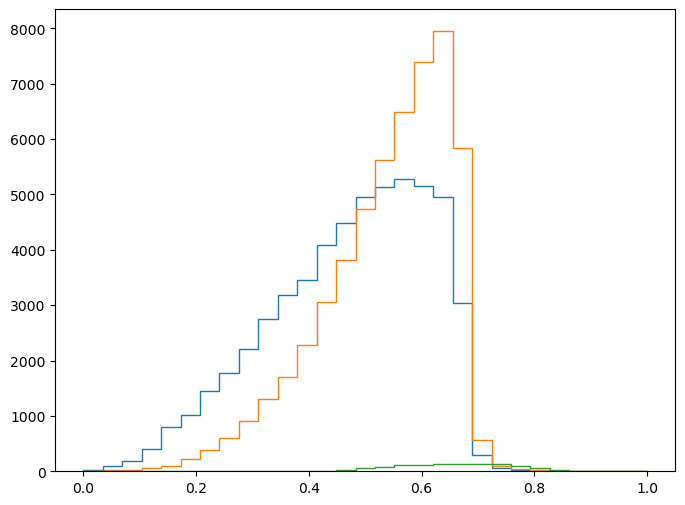

Epoch 20: 100%|██████████| 767/767 [00:20<00:00, 36.70it/s, v_num=72, val_loss=0.659, train_loss=0.660]

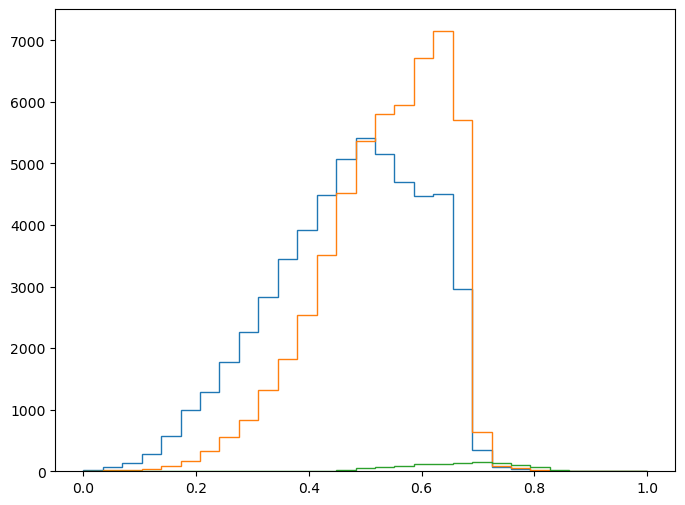

Epoch 21: 100%|██████████| 767/767 [00:19<00:00, 39.04it/s, v_num=72, val_loss=0.659, train_loss=0.660]

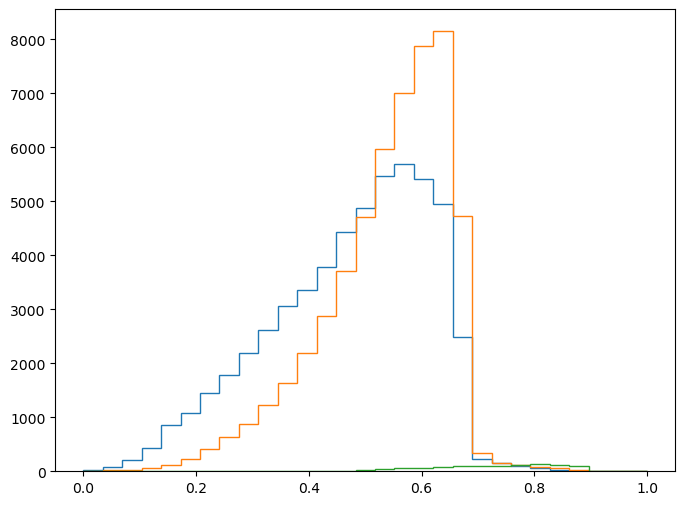

Epoch 22: 100%|██████████| 767/767 [00:18<00:00, 40.80it/s, v_num=72, val_loss=0.659, train_loss=0.660]

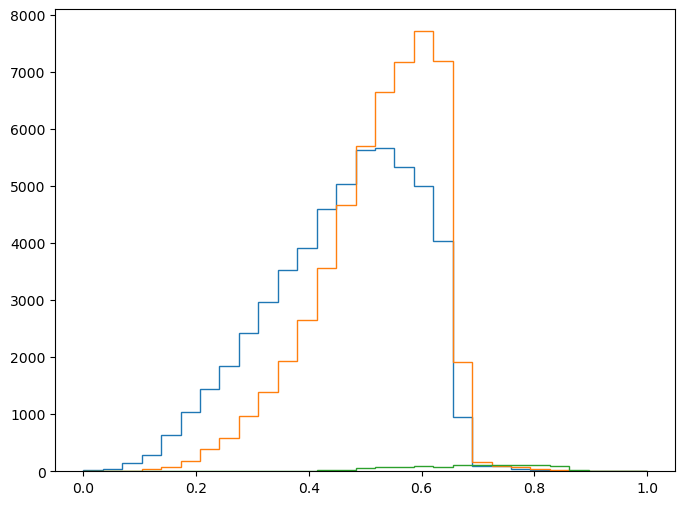

Epoch 23: 100%|██████████| 767/767 [00:19<00:00, 39.95it/s, v_num=72, val_loss=0.659, train_loss=0.659]

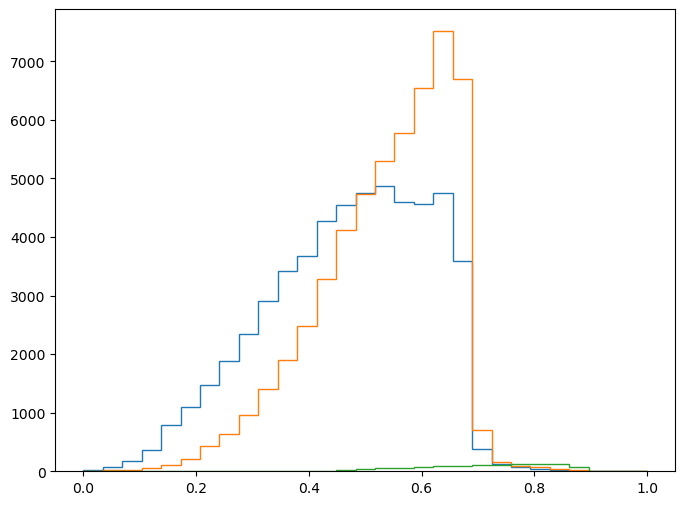

Epoch 24: 100%|██████████| 767/767 [00:18<00:00, 41.74it/s, v_num=72, val_loss=0.659, train_loss=0.659]

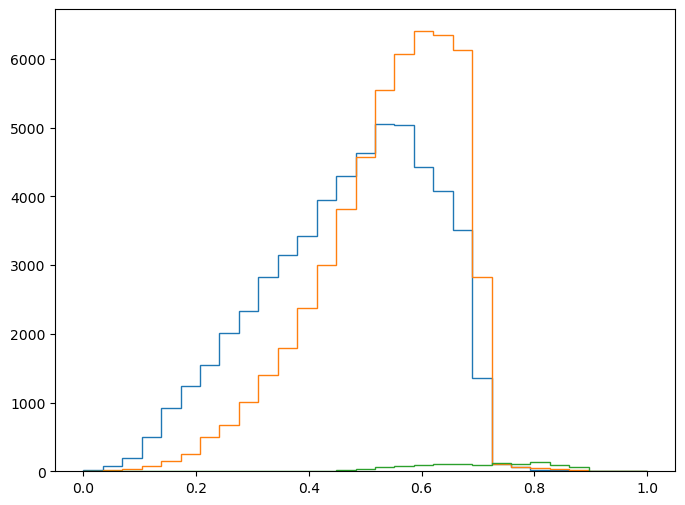

Epoch 25: 100%|██████████| 767/767 [00:18<00:00, 40.97it/s, v_num=72, val_loss=0.659, train_loss=0.659]

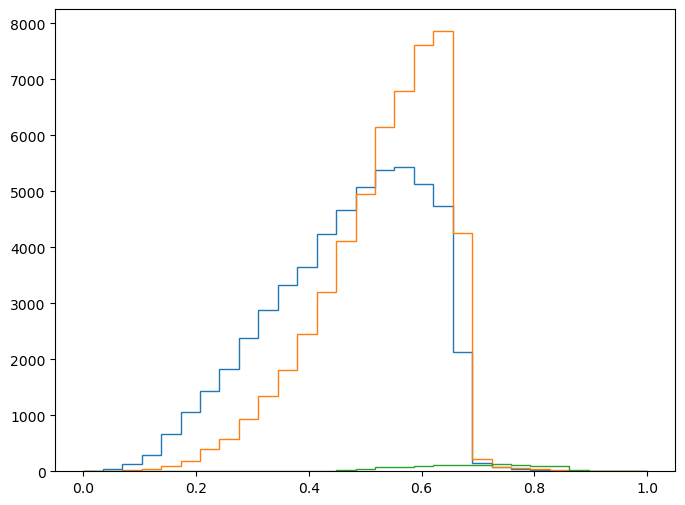

Epoch 26: 100%|██████████| 767/767 [00:17<00:00, 43.68it/s, v_num=72, val_loss=0.658, train_loss=0.659]

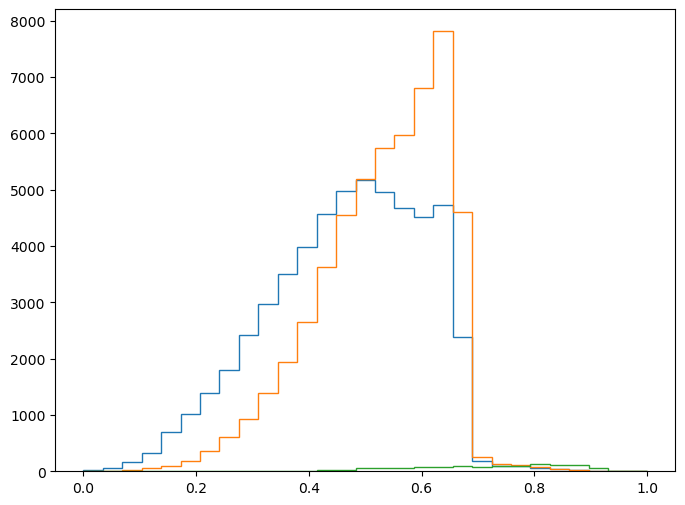

Epoch 27: 100%|██████████| 767/767 [00:19<00:00, 39.87it/s, v_num=72, val_loss=0.658, train_loss=0.659]

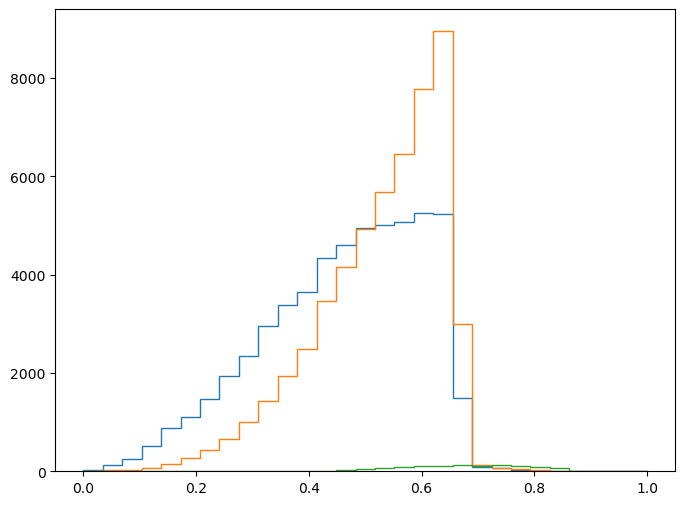

Epoch 28: 100%|██████████| 767/767 [00:17<00:00, 42.66it/s, v_num=72, val_loss=0.658, train_loss=0.659]

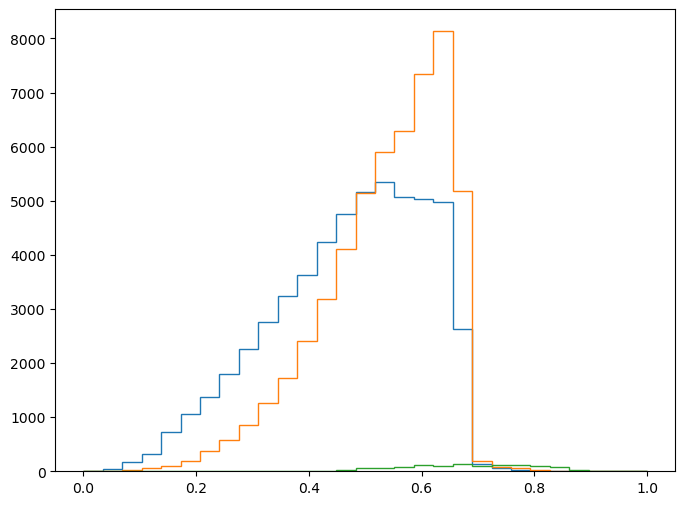

Epoch 29: 100%|██████████| 767/767 [00:17<00:00, 43.12it/s, v_num=72, val_loss=0.658, train_loss=0.659]

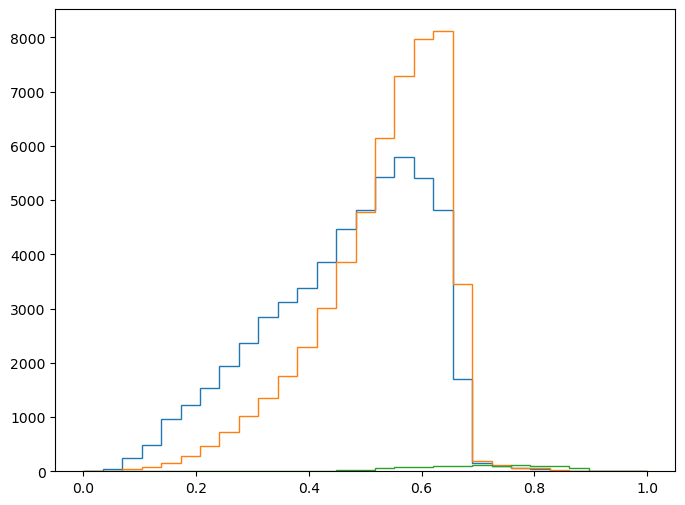

Epoch 29: 100%|██████████| 767/767 [00:25<00:00, 30.67it/s, v_num=72, val_loss=0.659, train_loss=0.659]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 767/767 [00:25<00:00, 30.62it/s, v_num=72, val_loss=0.659, train_loss=0.659]


FvTClassifier(
  (encoder): FvTEncoder(
    (canJetScaler): scaler()
    (dijetScaler): scaler()
    (quadjetScaler): scaler()
    (jetPtGBN): GhostBatchNorm1d()
    (jetEtaGBN): GhostBatchNorm1d()
    (jetMassGBN): GhostBatchNorm1d()
    (jetEmbed): conv1d(
      (module): Conv1d(4, 6, kernel_size=(1,), stride=(1,))
    )
    (dijetGBN): GhostBatchNorm1d()
    (dijetEmbed1): conv1d(
      (module): Conv1d(2, 6, kernel_size=(1,), stride=(1,))
    )
    (DijetResNetBlock): DijetResNetBlock(
      (reinforce1): DijetReinforceLayer(
        (conv): conv1d(
          (module): Conv1d(6, 6, kernel_size=(3,), stride=(3,), bias=False)
          (batchNorm): GhostBatchNorm1d()
        )
      )
      (convJ): conv1d(
        (module): Conv1d(6, 6, kernel_size=(1,), stride=(1,), bias=False)
        (batchNorm): GhostBatchNorm1d()
      )
      (reinforce2): DijetReinforceLayer(
        (conv): conv1d(
          (module): Conv1d(6, 6, kernel_size=(3,), stride=(3,))
        )
      )
    )
    (d

In [5]:
from dataset import generate_mother_dataset, split_scdinfo
import pytorch_lightning as pl
from training_info import TrainingInfoV2

from pl_callbacks import FvTScorePlotCallback

torch.set_float32_matmul_precision('medium')

dim_input_jet_features = 4
num_classes = 2

base_fvt_hparams = {
    "dim_dijet_features": 6,
    "dim_quadjet_features": 6,
    "lr": 1e-3,
    "batch_size": 1024,
    "max_epochs": 30,
    "train_seed": 42,
    "data_seed": 42,
    "val_ratio": 0.33,
    "fit_batch_size": True
}
base_fvt_train_ratio = 0.4

n_3b = 1400000
ratio_4b = 0.5
signal_ratio = 0.02
signal_filename = "HH4b_picoAOD.h5"
seed = 42


# 1. Generate the mother dataset
scdinfo_all, df_all = generate_mother_dataset(
    n_3b=n_3b,
    ratio_4b=ratio_4b,
    signal_ratio=signal_ratio,
    signal_filename=signal_filename,
    seed=seed,
)

# 2. Split the mother dataset into train and test
# Train -- validation split will be done by TrainingInfoV2

scdinfo_base_fvt, scdinfo_not_base_fvt = split_scdinfo(
    scdinfo_all, base_fvt_train_ratio, seed
)

pl.seed_everything(seed)
np.random.seed(seed)

base_fvt_tinfo = TrainingInfoV2(base_fvt_hparams, scdinfo_base_fvt)

base_fvt_train_dset, base_fvt_val_dset = (
    base_fvt_tinfo.fetch_train_val_tensor_datasets(
        features, "fourTag", "weight")
)

base_fvt_model = FvTClassifier(
    num_classes,
    dim_input_jet_features,
    base_fvt_hparams["dim_dijet_features"],
    base_fvt_hparams["dim_quadjet_features"],
    run_name="",
    device=torch.device("cuda:0"),
    lr=base_fvt_hparams["lr"],
)

events_rest = events_from_scdinfo(scdinfo_not_base_fvt, features, signal_filename)
events_rest.shuffle()
events_rest.trim(100_000)

base_fvt_model.fit(
    base_fvt_train_dset,
    base_fvt_val_dset,
    batch_size=base_fvt_hparams["batch_size"],
    max_epochs=base_fvt_hparams["max_epochs"],
    train_seed=base_fvt_hparams["train_seed"],
    save_checkpoint=False, 
    callbacks=[FvTScorePlotCallback(events_rest)],
)
base_fvt_model.eval()